# Exploring Chicago Food Inspections: 2011-2019

**Jennifer Sikora** <br>
**IS590-DV** <br>
**April 18, 2019**

Welcome to the Jupyter Notebook by Jennifer Sikora, in which we will explore the Chicago Department of Public Health's Food Inspections dataset. Each row in the dataset represents a food inspection. According to the description PDF accompanying the data, "This dataset contains information from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present."

Every year, the Chicago Department of Public Health conducts over thirteen thousand food inspections per year, across over four hundred facility types, including restaurants, day care centers, hospitals, mobile food dispensers, and taverns, to name a few. 

Please see the Sources section at the end of this document for the link to the full dataset. For the purposes of my visualizations, I have cleaned and paired down the dataset so it is more manageable. 

In [1]:
# Import libraries
import pandas as pd
import bqplot
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
import traitlets
import ipywidgets
import math
# plt.rcParams['figure.dpi'] = 150

In [2]:
inspections = pd.read_csv("/Users/jennifersikora/Downloads/inspections_cleaned.csv")

In [3]:
inspections_top5_2018 = pd.read_csv("/Users/jennifersikora/Downloads/inspections_top5_2018.csv")

## Visualizing the Number of Food Inspections by Year

### Exploring Counts

I will first visualize the count of inspections by year. As you can see below, the number of food inspections by year has remained fairly steady. Since the dataset was downloaded at the end of March 2019, the number of food inspections for 2019 is far lower than previous years. However, the first plot shows that there was a marked decline in the number of inspections conducted in 2018. Additionally, a greater percentage of those inspections were given a "Passed With Conditions" result. I do not know if the number of inspections fell in 2018, or perhaps the way the inspections were input into the database changed in 2018, resulting in the appearance that there were fewer inspections. The second plot shows that while the majority of the facilities do pass their inspections, there are still quite a few that passed with conditions or failed. 

Text(0.5, 1.0, 'Number of Food Inspections by Year and Results')

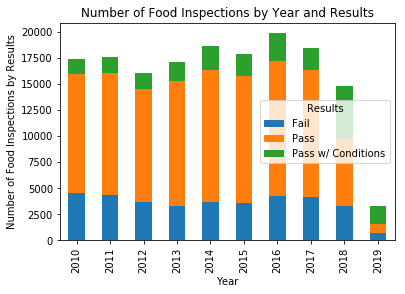

In [4]:
(inspections
 .groupby(['year', 'Results'])
 .size()
 .unstack()
 .plot.bar(stacked=True)
)

plt.xlabel("Year")
plt.ylabel("Number of Food Inspections by Results")
plt.title("Number of Food Inspections by Year and Results")

Text(0.5, 1.0, 'Number of Food Inspections by Results Type')

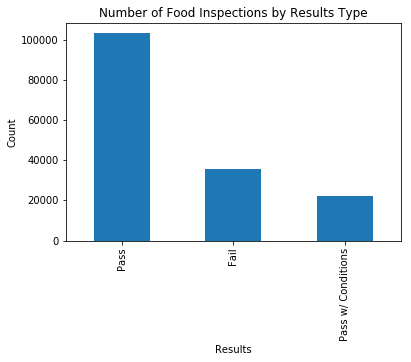

In [5]:
inspections["Results"].value_counts().plot(kind="bar")
plt.xlabel("Results")
plt.ylabel("Count")
plt.title("Number of Food Inspections by Results Type")

## Exploring Facilities & their Results with an Interactive Dashboard

Since there are 462 facility types in the original dataset, and any visualization featuring all 462 types would be challenging to decipher, subsequent visualizations will use a dataset using data from the top 5 facility types:

* Restaurant
* Grocery Store
* School
* Children's Services Facility
* Bakery

It should also be noted that since the original dataset spans a fairly wide time frame, and some of the business are closed, the visualizations presented here will only organizations that received one of the following results:

* Pass
* Fail
* Pass with Conditions


Using only the food inspections from 2018, I created an interactive dashboard that shows the number of food inspections by the top 5 facility types and the results.

By clicking on a cell of the heatmap, you will see a plot of the location of facilities that fall within that category. For instance, if you would like to see which restaurants failed their inspections in 2018, click on the appropriate cell on the heatmap and a scatterplot will show up on the right. When you hover over a point in the scatterplot, you will see the name, address, and risk level of that specific facility (hover feature in the works). The scatterplots show that there is not a specific area of the city where facilities are more likely to pass or fail the inspections; rather, the results are pretty evenly spread across the city. 

In [6]:
# Variables for the heatmap

x = inspections_top5_2018['Results']
y = inspections_top5_2018['Facility Type']
z = inspections_top5_2018['Results']

In [7]:
import numpy as np
xnames = x.unique()
ynames = y.unique()
znames = np.zeros([len(xnames),len(ynames)])

# loop and fill
for i,xn in enumerate(xnames):
   for j, yn in enumerate(ynames):
       mask = (x == xn) & (y == yn)
       znames[i,j] = z[mask].value_counts()

In [8]:
# Variables for the scatterplot

long = inspections_top5_2018["Longitude"]
lat = inspections_top5_2018["Latitude"]
risks = inspections_top5_2018["Risk"]
names = inspections_top5_2018["DBA Name"]
addresses = inspections_top5_2018["Address"]

In [9]:
# Grammar of Graphics

# PART I: HEATMAP

# Scales
x_sc = bqplot.OrdinalScale()
y_sc = bqplot.OrdinalScale()
col_sc = bqplot.ColorScale(scheme="Blues")

# Axes
x_ax = bqplot.Axis(scale=x_sc, 
                   label='Facility Type',
                   tick_rotate=-30,
                   tick_style={'tick-offset':'10px', 'text-anchor':'middle'})
y_ax = bqplot.Axis(scale=y_sc, orientation='vertical',
                   label='Results')
c_ax = bqplot.ColorAxis(scale=col_sc, orientation='vertical', side='right')

# Marks
heat_map = bqplot.GridHeatMap(color=znames,
                              row=xnames,
                              column=ynames,
                             scales = {'row':y_sc,
                                      'column':x_sc,
                                      'color':col_sc},
                             interactions = {'click':'select'},
                             anchor_style = {'fill':'gray'},
                              selected_style = {'opacity':1.0},
                              unselected_style = {'opacity':0.8}
                             )

# Create figure
fig_heatmap = bqplot.Figure(marks=[heat_map], axes=[x_ax, y_ax, c_ax],
                   title="Results by Facility Type")

# PART II: SCATTERPLOT

# Scales 
x_sc2 = bqplot.LinearScale()
y_sc2 = bqplot.LinearScale()
c_sc2 = bqplot.OrdinalColorScale(domain=risks.unique().tolist(), 
                               colors=bqplot.CATEGORY10[:4])

# Axes
x_ax2 = bqplot.Axis(scale=x_sc2, 
                    label='Longitude')
y_ax2 = bqplot.Axis(scale=y_sc2, label='Latitude', orientation='vertical')
c_ax2 = bqplot.ColorAxis(scale=c_sc2, 
                         label="Risk", 
                         orientation="vertical",
                         side="right")

# Tooltip
tt = bqplot.Tooltip( fields = ['names',
                               'addresses',
                               'risks'
                             ],
                 labels =['Business Name', 
                          'Address',
                          'Risk']
                   )

# Marks
# Scatters:
scatters = bqplot.Scatter( x=long, 
                          y=lat, 
                          color=risks,
                          scales={'x':x_sc2, 'y':y_sc2, 'color':c_sc2},
                          tooltip=tt
                         )

# Create figure
fig_scatters = bqplot.Figure(title="Location of Facilities", 
                    marks=[scatters], axes=[x_ax2,y_ax2, c_ax2])

# Create a mask
i, j = "Pass", "Restaurant"
mask = ( (inspections_top5_2018["Results"]=="Pass") & (inspections_top5_2018["Facility Type"]=="Restaurant") )

# Label
mySelectedLabel = ipywidgets.Label()

# Linking Function
def get_data_value2(change):
    i,j = change['owner'].selected[0]
    v = znames[i,j]
    mySelectedLabel.value = 'Total number of inspections = ' + str(v)

    mask = ( (inspections_top5_2018["Results"].values==xnames[i]) & 
            (inspections_top5_2018["Facility Type"].values==ynames[j]) )
    
    longitude = inspections_top5_2018["Longitude"]
    latitude = inspections_top5_2018["Latitude"]

    scatters.x = longitude[mask]
    scatters.y = latitude[mask]

heat_map.observe(get_data_value2, 'selected')

ipywidgets.VBox([mySelectedLabel, ipywidgets.HBox([fig_heatmap,fig_scatters])])

## Resources:
* Food Inspections, Chicago Department of Public Health's Food Protection Program. Chicago Data Portal. Accessed April 1, 2019. URL: https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5 